In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import h5py
import json
import os

from cell_inference.config import paths, params
from cell_inference.utils.plotting.plot_results import plot_lfp_traces, plot_lfp_heatmap
from cell_inference.utils.feature_extractors.SummaryStats2D import calculate_stats, build_lfp_grid
from cell_inference.utils.feature_extractors.parameterprediction import ClassifierTypes, ClassifierBuilder

%matplotlib inline

## Load simulation data

In [2]:
DATA_PATH = 'cell_inference/resources/simulation_data'
TRIAL_PATH = os.path.join(DATA_PATH, 'neuronal_model_491766131_tuned_Loc5')

CONFIG_PATH = os.path.join(TRIAL_PATH, 'config.json')  # trial configuration
LFP_PATH = os.path.join(TRIAL_PATH, 'lfp.npz')  # LFP and labels
STATS_PATH = os.path.join(TRIAL_PATH, 'summ_stats.npz')  # summary statistics

with open(CONFIG_PATH, 'r') as f:
    config_dict = json.load(f)

inference_list = config_dict['Trial_Parameters']['inference_list']
print(inference_list)

STATS = np.load(STATS_PATH)
summ_stats = STATS['x']
labels = STATS['y']
df_la = pd.DataFrame(labels, columns=inference_list)
has_yshift = 'y' in inference_list and STATS['ys'].size != 0
if has_yshift:
    ys_idx = inference_list.index('y')
    labels[:,ys_idx] = STATS['ys']
    df_la.sort_values(by='y',inplace=True)

with pd.option_context('display.max_rows',10):
    display(df_la)

['y', 'd', 'theta', 'h', 'phi']


,y,d,theta,h,phi
5800,-156.663834,190.756733,0.058864,-0.967159,2.118687
5305,-150.761216,183.347261,-0.043687,-0.991439,-2.537946
593,-150.403880,188.252553,-0.347951,-0.751045,-2.030110
5257,-146.829250,179.169166,-0.076148,-0.991636,2.387392
1117,-145.124170,195.795708,-0.152879,-0.944600,-2.627912
...,...,...,...,...,...
34,136.914160,174.899237,0.188002,0.971356,2.227632
3599,141.933148,189.717501,-0.377533,0.708085,-2.134145
1900,143.942632,193.243665,0.238725,0.967190,-2.975081
3546,145.390511,188.388047,-0.015920,0.990473,-2.917282


### Normalizing labels

#### Set bounds for y shift

In [3]:
ranges = config_dict['Simulation_Parameters']['loc_param_range']
ranges.update(config_dict['Simulation_Parameters']['geo_param_range'])
print(json.dumps(ranges))

if has_yshift:
    ranges['y'] = [-150, 150]
    df_la_idx = df_la[df_la['y'].between(*ranges['y'])].index.values
    labels = labels[df_la_idx,:]
    summ_stats = summ_stats[df_la_idx,:]
    with pd.option_context('display.max_rows',10):
        display(df_la.loc[df_la_idx])

{"x": [-50, 50], "y": [-1400, 1400], "z": [20.0, 200.0], "alpha": [0, 3.141592653589793], "h": [-1.0, 1.0], "phi": [-3.141592653589793, 3.141592653589793], "d": [20.0, 200.0], "theta": [-1.0471975511965976, 1.0471975511965976], "r_s": [5.0, 12.0], "l_t": [20.0, 800.0], "r_t": [0.2, 0.8], "r_d": [0.1, 0.5], "r_tu": [0.05, 0.4], "l_d": [100.0, 300.0], "r_a": [0.1, 0.5], "r_o": [0.1, 0.5], "l_o": [10.0, 150]}


,y,d,theta,h,phi
5257,-146.829250,179.169166,-0.076148,-0.991636,2.387392
1117,-145.124170,195.795708,-0.152879,-0.944600,-2.627912
3182,-143.376419,159.567036,-0.147402,-0.980878,-2.079992
1546,-141.343453,163.594114,0.067867,-0.925183,2.013953
3751,-139.621181,165.082371,-0.587879,-0.878355,1.433035
...,...,...,...,...,...
2910,135.915803,198.762469,0.506645,0.943772,-2.974768
34,136.914160,174.899237,0.188002,0.971356,2.227632
3599,141.933148,189.717501,-0.377533,0.708085,-2.134145
1900,143.942632,193.243665,0.238725,0.967190,-2.975081


#### Normalization

In [4]:
feature_range = (-1, 1)
norm_scale = lambda x, r: (x - r[0]) / (r[1] - r[0]) * (feature_range[1] - feature_range[0]) + feature_range[0]
org_scale = lambda x, r: (x - feature_range[0]) / (feature_range[1] - feature_range[0]) *  (r[1] - r[0]) + r[0]

for i, lb in enumerate(inference_list):
    labels[:,i] = norm_scale(labels[:,i], ranges[lb])

df_la = pd.DataFrame(labels, columns=inference_list)
with pd.option_context('display.max_rows',10):
    display(df_la)

,y,d,theta,h,phi
0,-0.978862,0.768546,-0.072716,-0.991636,0.759931
1,-0.967494,0.953286,-0.145989,-0.944600,-0.836490
2,-0.955843,0.550745,-0.140758,-0.980878,-0.662082
3,-0.942290,0.595490,0.064808,-0.925183,0.641061
4,-0.930808,0.612026,-0.561383,-0.878355,0.456149
...,...,...,...,...,...
5936,0.906105,0.986250,0.483810,0.943772,-0.946898
5937,0.912761,0.721103,0.179529,0.971356,0.709077
5938,0.946221,0.885750,-0.360517,0.708085,-0.679319
5939,0.959618,0.924930,0.227966,0.967190,-0.946998


## Build model

In [5]:
import torch
from cell_inference.utils.feature_extractors.fullyconnectednetwork import FullyConnectedNetwork, ActivationTypes
# from cell_inference.utils.feature_extractors.convolutionalnetwork import ConvolutionalNetwork

isTrain = False
model_name = 'FCN_batch256.pth'
MODEL_PATH = os.path.join(TRIAL_PATH,model_name)

model = FullyConnectedNetwork(in_features=summ_stats.shape[1], out_features=labels.shape[1])

## Train model

In [6]:
from cell_inference.utils.feature_extractors.helperfunctions import train_regression, build_dataloader_from_numpy

train_loader, test_loader = build_dataloader_from_numpy(input_arr=summ_stats, labels_arr=labels, batch_size=256, shuffle=True)
if isTrain:
    history = train_regression(model, train_loader, test_loader, epochs=100, learning_rate=0.001, decay_rate=0.98)
    model.eval()
    torch.save(model.state_dict(), MODEL_PATH)

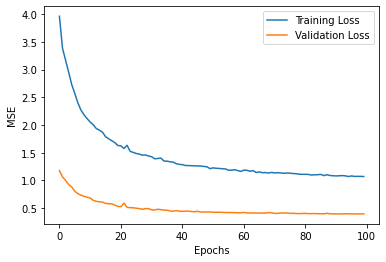

In [7]:
isTrain = False
if not isTrain:
    LOSS_PATH = 'cell_inference/resources/results/pytorch_losses'
    loss_file = '23_53_30__07_23_2022.csv' # select data
    history = pd.read_csv(os.path.join(LOSS_PATH, loss_file)).to_dict(orient='list')
plt.figure()
plt.plot(history['Epochs'],history['Training_Loss'],label='Training Loss')
plt.plot(history['Epochs'],history['Validation_Loss'],label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()

## Evaluate model

In [8]:
if not isTrain:
    model.load_state_dict(torch.load(MODEL_PATH))

### Perform on stylized model

In [9]:
from sklearn.metrics import r2_score
from cell_inference.utils.transform.geometry_transformation import hphi2unitsphere, unitsphere2hphi, trivarnorm2unitsphere
from cell_inference.utils.metrics.corrcoef import corrcoef

device = torch.device("cpu")
model.eval()

y = []
output = []
for X, Y in test_loader:
    y.append(Y.to("cpu").detach().numpy())
    output.append(model(X.to(device)).to("cpu").detach().numpy())
y = np.concatenate(y, axis=0)
output = np.concatenate(output, axis=0)

# print("R2: {}".format(r2_score(y, output)))
for i, p in enumerate(inference_list):
    if has_yshift and i == ys_idx:
        p = 'y-shift'
    print('R2 Score {:10} {:.3f}'.format(p+':', r2_score(y[:,i], output[:,i])))

# back to original scale
for i, lb in enumerate(inference_list):
    y[:,i] = org_scale(y[:,i], ranges[lb])
    output[:,i] = org_scale(output[:,i], ranges[lb])

df_la = pd.DataFrame(y, columns=inference_list).sort_values(by='y')
display(df_la)

R2 Score y-shift:   0.823
R2 Score d:         0.914
R2 Score theta:     0.621
R2 Score h:         0.957
R2 Score phi:       0.736


,y,d,theta,h,phi
933,-130.888565,185.407867,0.158554,-0.971307,-3.014340
1030,-122.568192,183.820374,-0.603395,-0.816592,1.359270
606,-115.049698,193.758347,-0.037914,-0.892169,2.085753
1387,-114.184776,190.014099,-0.276447,-0.963395,-2.798777
1046,-111.717316,101.610092,0.197961,-0.324186,1.378123
...,...,...,...,...,...
1415,112.881958,159.069595,0.223197,0.972246,-2.375841
8,113.052521,122.271683,0.316470,-0.230048,2.138961
807,118.711639,189.463150,-0.008118,0.929276,2.702790
541,128.810669,192.426010,-0.092782,0.676921,1.729180


Stylized Cell Testing Data: Ground Truth VS Predicted


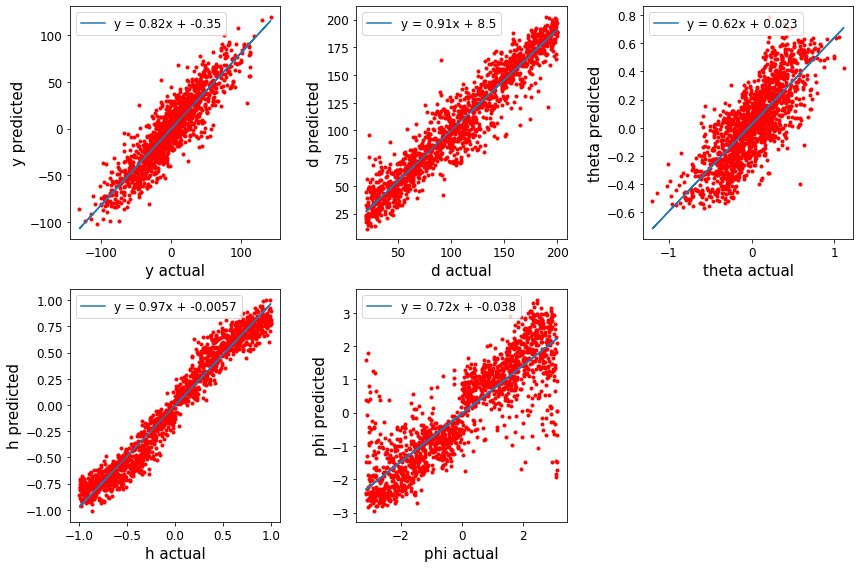

In [10]:
nlb = len(inference_list)
nrows = int(np.ceil(nlb/3))

fontsize = 15
labelsize = 12
print("Stylized Cell Testing Data: Ground Truth VS Predicted")

plt.figure(figsize=(12, 4 * nrows))
for i, lb in enumerate(inference_list):
    ax = plt.subplot(nrows, 3, i+1)
    ax.scatter(y[:,i], output[:,i], c='red', marker='.')
    m, b = np.polyfit(y[:,i], output[:,i], 1)
    ax.plot(y[:,i], m * y[:,i] + b, label='y = %.2gx + %.2g' % (m,b))
    ax.set_xlabel(lb + ' actual', fontsize=fontsize)
    ax.set_ylabel(lb + ' predicted', fontsize=fontsize)
    ax.tick_params(labelsize=labelsize)
    ax.legend(loc=2, fontsize=labelsize)
plt.tight_layout()
plt.show()

#### Check prediction on orientation

In [11]:
check_orient = 'h' in inference_list and 'phi' in inference_list
if check_orient:
    orient_idx = [inference_list.index(x) for x in ['h', 'phi']]
    
    from cell_inference.utils.transform.geometry_transformation import hphi2unitsphere
    def cosine_similarity(hphi1, hphi2):
        np.clip(hphi1[:,0], -1, 1, out=hphi1[:,0])
        np.clip(hphi2[:,0], -1, 1, out=hphi2[:,0])
        x1 = hphi2unitsphere(hphi1)
        x2 = hphi2unitsphere(hphi2)
        return np.sum(x1 * x2, axis=1)

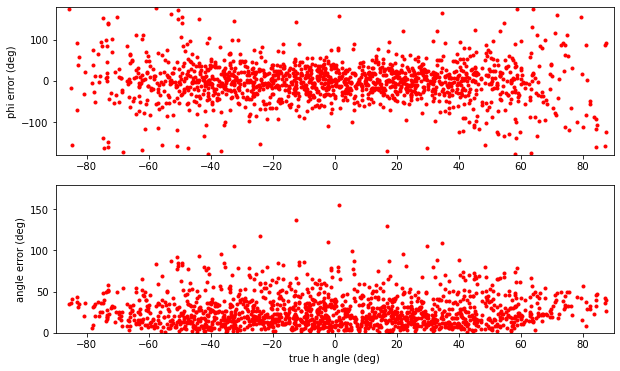

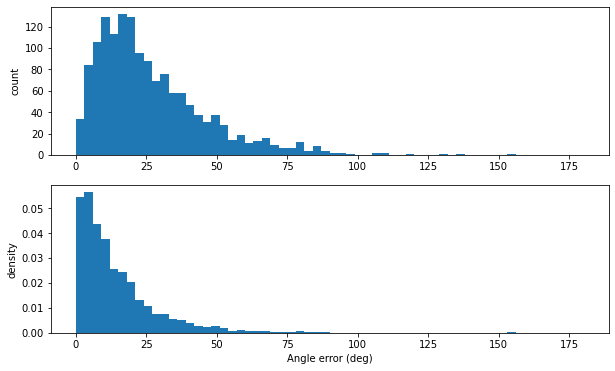

In [12]:
angle = np.arccos(cosine_similarity(y[:, orient_idx], output[:, orient_idx]))
weights = 1 / np.sin(angle)
angle *= 180 / np.pi
phi_err = 180 / np.pi * (output[:, orient_idx[1]] - y[:, orient_idx[1]])
phi_err = np.mod(phi_err + 180, 360) - 180
h_angle = 90 - 180 / np.pi * np.arccos(y[:, orient_idx[0]])
bins = 60

plt.figure(figsize=(10,6))
# phi error vs. h angle
plt.subplot(211)
plt.plot(h_angle, phi_err, 'r.')
plt.xlim([-90, 90])
plt.ylim([-180, 180])
plt.ylabel('phi error (deg)')
# angle error vs. h angle
plt.subplot(212)
plt.plot(h_angle, angle, 'r.')
plt.xlim([-90, 90])
plt.ylim([0, 180])
plt.xlabel('true h angle (deg)')
plt.ylabel('angle error (deg)')

# angle error distribution
plt.figure(figsize=(10,6))
plt.subplot(211)
_ = plt.hist(angle, bins=bins, range=(0, 180))
plt.ylabel('count')
plt.subplot(212)
_ = plt.hist(angle, bins=bins, range=(0, 180), density=True, weights=weights)
plt.ylabel('density') # probability density of angle error per area on the unit sphere
plt.xlabel('Angle error (deg)')

plt.show()

### Perform on detailed model (Random cases)

In [13]:
LFP_PATH = os.path.join(TRIAL_PATH, 'lfp_detailed.npz')  # LFP and labels
STATS_PATH = os.path.join(TRIAL_PATH, 'summ_stats_detailed.npz')  # summary statistics

#### Ground truth

In [14]:
STATS = np.load(STATS_PATH)
summ_stats_test = STATS['x']
labels_true = STATS['y']
if has_yshift:
    labels_true[:, ys_idx] = STATS['ys']

df_la_true = pd.DataFrame(labels_true, columns=inference_list)

#### Prediction

In [15]:
device = torch.device("cpu")
model.eval()

labels_pred = model(torch.Tensor(summ_stats_test).to(device)).to("cpu").detach().numpy()

# back to original scale
for i, lb in enumerate(inference_list):
    labels_pred[:,i] = org_scale(labels_pred[:,i], ranges[lb])

df_la_pred = pd.DataFrame(labels_pred, columns=inference_list)

for i, p in enumerate(inference_list):
    if has_yshift and i == ys_idx:
        p = 'y-shift'
    print('R2 Score {:10} {:.3f}'.format(p+':', r2_score(labels_true[:,i], labels_pred[:,i])))

R2 Score y-shift:   0.076
R2 Score d:         -0.287
R2 Score theta:     0.512
R2 Score h:         0.699
R2 Score phi:       0.471


Detailed Cell Testing Data: Ground Truth VS Predicted


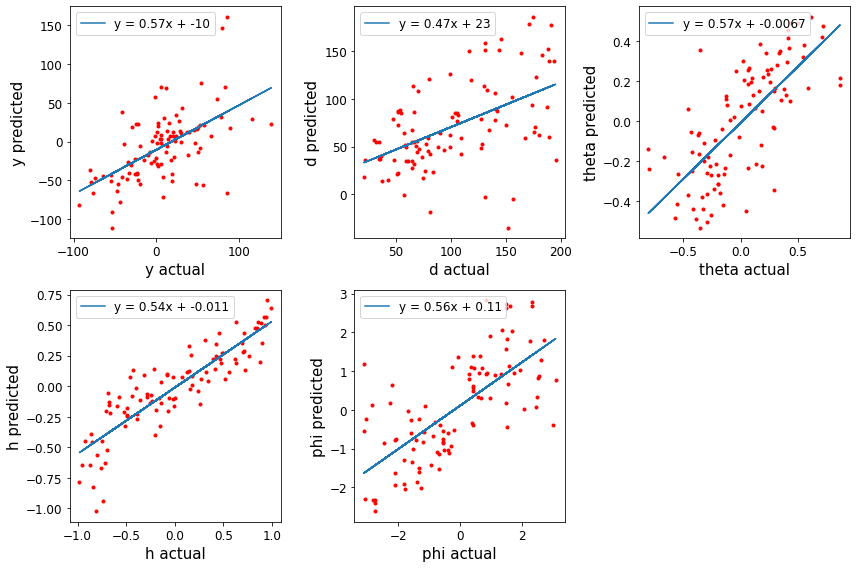

In [16]:
nlb = len(inference_list)
nrows = int(np.ceil(nlb/3))

fontsize = 15
labelsize = 12
print("Detailed Cell Testing Data: Ground Truth VS Predicted")

plt.figure(figsize=(12, 4 * nrows))
for i, lb in enumerate(inference_list):
    ax = plt.subplot(nrows, 3, i+1)
    ax.scatter(labels_true[:,i], labels_pred[:,i], c='red', marker='.')
    m, b = np.polyfit(labels_true[:,i], labels_pred[:,i], 1)
    ax.plot(labels_true[:,i], m * labels_true[:,i] + b, label='y = %.2gx + %.2g' % (m,b))
    ax.set_xlabel(lb + ' actual', fontsize=fontsize)
    ax.set_ylabel(lb + ' predicted', fontsize=fontsize)
    ax.tick_params(labelsize=labelsize)
    ax.legend(loc=2, fontsize=labelsize)
plt.tight_layout()
plt.show()

#### Check prediction on orientation

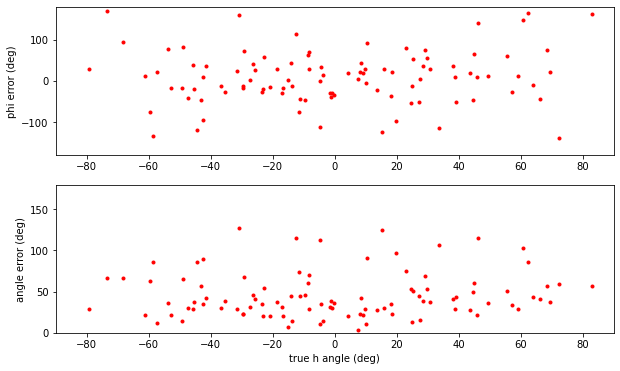

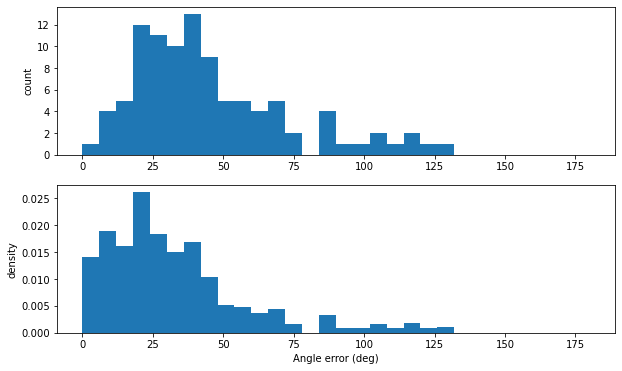

In [17]:
angle = np.arccos(cosine_similarity(labels_true[:, orient_idx], labels_pred[:, orient_idx]))
weights = 1 / np.sin(angle)
angle *= 180 / np.pi
phi_err = 180 / np.pi * (labels_pred[:, orient_idx[1]] - labels_true[:, orient_idx[1]])
phi_err = np.mod(phi_err + 180, 360) - 180
h_angle = 90 - 180 / np.pi * np.arccos(labels_true[:, orient_idx[0]])
bins = 30

plt.figure(figsize=(10,6))
# phi error vs. h angle
plt.subplot(211)
plt.plot(h_angle, phi_err, 'r.')
plt.xlim([-90, 90])
plt.ylim([-180, 180])
plt.ylabel('phi error (deg)')
# angle error vs. h angle
plt.subplot(212)
plt.plot(h_angle, angle, 'r.')
plt.xlim([-90, 90])
plt.ylim([0, 180])
plt.xlabel('true h angle (deg)')
plt.ylabel('angle error (deg)')

# angle error distribution
plt.figure(figsize=(10,6))
plt.subplot(211)
_ = plt.hist(angle, bins=bins, range=(0, 180))
plt.ylabel('count')
plt.subplot(212)
_ = plt.hist(angle, bins=bins, range=(0, 180), density=True, weights=weights)
plt.ylabel('density') # probability density of angle error per area on the unit sphere
plt.xlabel('Angle error (deg)')

plt.show()

### Perform on detailed model (Selected cases)

In [18]:
import os

DATA_PATH = 'cell_inference/resources/detailed'  # '/home/matt/data/InVivoLFPs/detailed_cell_simulation/without_basal_dendrite'
COORDS_PATH = os.path.join('cell_inference/resources', 'Electrode2D.h5')

# model_name = 'neuronal_model_496930324'
model_name = 'neuronal_model_491766131'
detailed_cells = [
    os.path.join(DATA_PATH, model_name+'_h0.0.h5'),
    os.path.join(DATA_PATH, model_name+'_h0.7071.h5'),
    os.path.join(DATA_PATH, model_name+'_h1.0.h5')
]

#### Ground truth

In [19]:
from cell_inference.utils.transform.geometry_transformation import pol2cart, cart2pol

loc_param = [0., 350., 80., np.pi/4, 1.0, 0.]
loc_params = np.tile(loc_param,(len(detailed_cells),1)) 
loc_params[:,4] = [0.0, 0.7071, 1.0]

labels_true = loc_params[:,[1,0,2,4,5]]
labels_true[:,1], labels_true[:,2] = cart2pol(labels_true[:,1], labels_true[:,2])

In [20]:
import h5py
from cell_inference.utils.feature_extractors.SummaryStats2D import build_lfp_grid, get_y_window, calculate_stats
from cell_inference.utils.spike_window import first_pk_tr, get_spike_window

pk_tr_idx_in_window = 24  # 24*0.025=0.6 ms
lfp_list = []
tt = []

summ_stats_test = []
bad_indices = []
yshift = []

amp_scale = 1.
for i, sample in enumerate(detailed_cells):
    with h5py.File(sample, "r") as f:
        lfp = f['data'][:].reshape((-1, 384)) * amp_scale
        dt = f.attrs['dt']

    start, end = get_spike_window(lfp, win_size=params.WINDOW_SIZE, align_at=pk_tr_idx_in_window)
    lfp_list.append(lfp[start:end,:])
    tt.append(np.arange(lfp.shape[0])[start:end] * dt)
    
    try:
        g_lfp, _, y_c = build_lfp_grid(lfp_list[i], params.ELECTRODE_POSITION[:, :2], y_window_size=960.0)
    except ValueError:
        bad_indices.append(i)
        continue
    summ_stats_test.append(calculate_stats(g_lfp))
    if has_yshift:
        yshift.append(y_c - labels_true[i, ys_idx])

summ_stats_test = np.array(summ_stats_test)
labels_true = np.delete(labels_true, bad_indices, axis=0)
if has_yshift:
    labels_true[:, ys_idx] = np.array(yshift)
print('%d bad samples.' % len(bad_indices))

df_la_true = pd.DataFrame(labels_true, columns=inference_list)

0 bad samples.


#### Prediction

In [21]:
device = torch.device("cpu")
model.eval()

labels_pred = model(torch.Tensor(summ_stats_test).to(device)).to("cpu").detach().numpy()

# back to original scale
for i, lb in enumerate(inference_list):
    labels_pred[:,i] = org_scale(labels_pred[:,i], ranges[lb])

df_la_pred = pd.DataFrame(labels_pred, columns=inference_list)

In [22]:
df_comp = {}
for c1, c2 in zip(df_la_true.columns, df_la_pred.columns):
    df_comp[c1+' true'] = df_la_true[c1]
    df_comp[c1+' pred'] = df_la_pred[c2]
df_comp = pd.DataFrame(df_comp)

# rad to degree
rad2deg = lambda x: 180 / np.pi * x

for p in ['theta', 'h', 'phi']:
    idx = df_comp.columns.get_loc(p + ' pred') + 1
    for d in [' pred', ' true']:
        val = df_comp[p + d]
        if p == 'h':
            val = np.pi/2 - np.arccos(val)
        df_comp.insert(idx, p + d + ' (degree)', rad2deg(val))

with pd.option_context('display.float_format', '{:.4g}'.format, 'max_columns', None):
    display(df_comp)

,y true,y pred,d true,d pred,theta true,theta pred,theta true (degree),theta pred (degree),h true,h pred,h true (degree),h pred (degree),phi true,phi pred,phi true (degree),phi pred (degree)
0,0,2.955,80,55.42,0,-0.1654,0,-9.478,0,0.08211,0,4.71,0,-1.004,0,-57.55
1,-20,-27.88,80,52.46,0,-0.0009493,0,-0.05439,0.7071,0.4358,45,25.84,0,-0.903,0,-51.74
2,-40,-41.22,80,52.47,0,0.02789,0,1.598,1,0.6856,90,43.29,0,-0.1247,0,-7.146
